In [1]:
# Install necessary packages
!pip install numpy
!pip install pandas matplotlib seaborn
!pip install scikit-surprise

# After installation, import the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For collaborative filtering using Surprise
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split as surprise_split, GridSearchCV

# Set display options for better output readability
pd.set_option('display.max_columns', None)


In [12]:
# 2.1 Load the "customers" (main) table
customers_df = pd.read_csv('customers_with_clusters.csv')
print("Customers Table Shape:", customers_df.shape)
print(customers_df.head())

# 2.2 Load the "transactions" table
transactions_df = pd.read_csv('transactions_summary.csv')
print("Transactions Table Shape:", transactions_df.shape)
print(transactions_df.head())

# 2.3 Ensure both have 'customer_id' as string for consistent merging
customers_df['customer_id'] = customers_df['customer_id'].astype(str)
transactions_df['customer_id'] = transactions_df['customer_id'].astype(str)

# 2.4 Merge with the customers table as LEFT
merged_df = pd.merge(
    customers_df,
    transactions_df,
    on='customer_id',
    how='left'
)

print("Merged Data Shape:", merged_df.shape)
merged_df.head()

Customers Table Shape: (9429, 17)
   customer_id  age          job   marital  education  credit_default  \
0            1   38  blue-collar   married  secondary               0   
1            3   73     services  divorced  secondary               0   
2            4   87      retired   married    primary               0   
3            6   46   technician   married   tertiary               0   
4            7   70        admin   married   tertiary               0   

   customer_segment region  income  credit_card  personal_loan  mortgage  \
0        High-Value  Urban    2603            1              1         1   
1  Budget-Conscious  Urban    3130            1              0         0   
2           Retired  Urban    2401            1              1         0   
3     Middle-Market  Urban    3355            1              1         0   
4  Budget-Conscious  Urban    4918            1              1         1   

   savings_account  investment_product  auto_loan  wealth_management  

,customer_id,age,job,marital,education,credit_default,customer_segment,region,income,credit_card,personal_loan,mortgage,savings_account,investment_product,auto_loan,wealth_management,Cluster,days_since_last_transaction,current_balance,peak_month,peak_month_spending,peak_month_frequency,total_transactions_3m,total_transactions_6m,total_transactions_12m,total_transaction_amount_3m,total_transaction_amount_6m,total_transaction_amount_12m,average_transaction_amount_3m,average_transaction_amount_6m,average_transaction_amount_12m,transaction_frequency_3m,transaction_frequency_6m,transaction_frequency_12m,high_value_transaction_rate_3m,high_value_transaction_rate_6m,high_value_transaction_rate_12m,online_transaction_ratio_3m,online_transaction_ratio_6m,online_transaction_ratio_12m
0,1,38,blue-collar,married,secondary,0,High-Value,Urban,2603,1,1,1,1,1,1,1,1,11,5694.487702,11,12893.350846,48,95,217,411,14545.179016,29958.358715,57718.686638,153.107148,138.056953,140.434761,31.666667,36.166667,34.250000,0.115789,0.078341,0.053528,0.622103,0.748928,0.680343
1,3,73,services,divorced,secondary,0,Budget-Conscious,Urban,3130,1,0,0,0,1,1,0,0,33,6638.183864,9,5563.095304,25,69,162,252,10717.607838,24831.656842,28871.833045,155.327650,153.281832,114.570766,23.000000,27.000000,21.000000,0.130435,0.141975,0.123016,0.502275,0.488544,0.594546
2,4,87,retired,married,primary,0,Retired,Urban,2401,1,1,0,1,0,0,0,0,0,4850.871858,6,3312.311841,15,46,90,153,5781.801272,9324.211041,14030.908555,125.691332,103.602345,91.705285,15.333333,15.000000,12.750000,0.130435,0.111111,0.091503,0.405197,0.470144,0.495167
3,6,46,technician,married,tertiary,0,Middle-Market,Urban,3355,1,1,0,1,0,1,1,1,29,9230.253144,2,26961.491731,52,97,152,467,16805.007014,42354.805258,116077.542773,173.247495,278.650035,248.560049,32.333333,25.333333,38.916667,0.082474,0.138158,0.089936,0.656706,0.649965,0.637181
4,7,70,admin,married,tertiary,0,Budget-Conscious,Urban,4918,1,1,1,1,0,1,0,0,16,6118.843752,5,10021.024507,35,84,192,311,21384.700365,28913.365031,40822.343394,254.579766,150.590443,131.261554,28.000000,32.000000,25.916667,0.178571,0.156250,0.160772,0.517893,0.442836,0.476606


Merged DF Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9429 entries, 0 to 9428
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   customer_id                      9429 non-null   object 
 1   age                              9429 non-null   int64  
 2   job                              9429 non-null   object 
 3   marital                          9429 non-null   object 
 4   education                        9429 non-null   object 
 5   credit_default                   9429 non-null   int64  
 6   customer_segment                 9429 non-null   object 
 7   region                           9429 non-null   object 
 8   income                           9429 non-null   int64  
 9   credit_card                      9429 non-null   int64  
 10  personal_loan                    9429 non-null   int64  
 11  mortgage                         9429 non-null   int64  
 12  savi

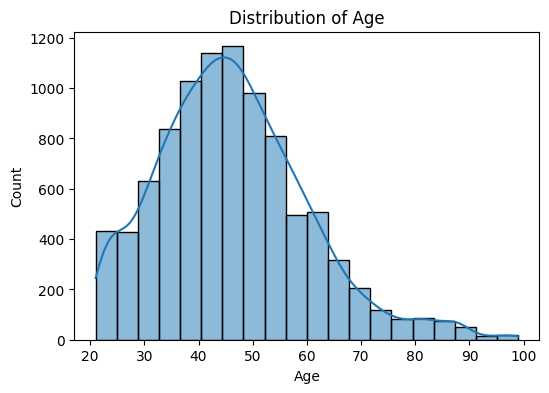

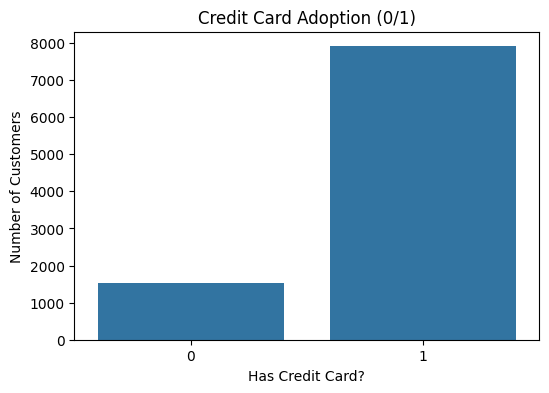

In [13]:
# 3.1 Check basic info
print("Merged DF Info:")
print(merged_df.info())

# 3.2 Check for missing values
missing_counts = merged_df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# 3.3 Quick EDA
# Example: distribution of age
plt.figure(figsize=(6,4))
sns.histplot(merged_df['age'].dropna(), bins=20, kde=True)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Example: how many customers have credit_card=1 vs 0
plt.figure(figsize=(6,4))
sns.countplot(x='credit_card', data=merged_df)
plt.title("Credit Card Adoption (0/1)")
plt.xlabel("Has Credit Card?")
plt.ylabel("Number of Customers")
plt.show()


In [14]:
# 4.1 Fill or handle missing numeric columns with median if needed
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if merged_df[col].isnull().sum() > 0:
        median_val = merged_df[col].median()
        merged_df[col].fillna(median_val, inplace=True)

# 4.2 Create additional features

# Example: total_products for each customer from the product columns
product_cols = [
    'credit_card', 'personal_loan', 'mortgage', 'savings_account',
    'investment_product', 'auto_loan', 'wealth_management'
]
merged_df['total_products'] = merged_df[product_cols].sum(axis=1)

# Example: average_transaction_amount (12m) to current_balance ratio
# if current_balance is non-zero
merged_df['balance_ratio'] = merged_df.apply(
    lambda row: row['average_transaction_amount_12m'] / row['current_balance']
                if row['current_balance'] != 0 else 0,
    axis=1
)

# Example: "engagement_score" combining multiple transaction-based metrics
# Here we do a simplistic approach: average of total_transaction_amount_12m and transaction_frequency_12m
# scaled by some factor (this is purely illustrative)
max_amount_12m = merged_df['total_transaction_amount_12m'].max()
max_freq_12m = merged_df['transaction_frequency_12m'].max()

merged_df['engagement_score'] = (
    (merged_df['total_transaction_amount_12m'] / max_amount_12m) +
    (merged_df['transaction_frequency_12m'] / max_freq_12m)
) / 2  # average of normalized amounts and frequency

print("Feature Engineering Done. Sample columns:")
merged_df[['customer_id', 'total_products', 'balance_ratio', 'engagement_score']].head()


Feature Engineering Done. Sample columns:


,customer_id,total_products,balance_ratio,engagement_score
0,1,7,0.024662,0.322198
1,3,3,0.017259,0.195244
2,4,3,0.018905,0.117303
3,6,5,0.026929,0.383976
4,7,5,0.021452,0.242794


In [15]:
# 5.1 Identify the product columns (already 0/1)
product_cols = [
    'credit_card', 'personal_loan', 'mortgage', 'savings_account',
    'investment_product', 'auto_loan', 'wealth_management'
]

# 5.2 Melt the wide format to a long format
interactions_df = merged_df.melt(
    id_vars=['customer_id', 'age', 'job', 'marital', 'education', 'credit_default',
             'customer_segment', 'region', 'income', 'Cluster',
             'days_since_last_transaction', 'current_balance', 'peak_month',
             'peak_month_spending', 'peak_month_frequency',
             'total_transactions_3m', 'total_transactions_6m', 'total_transactions_12m',
             'total_transaction_amount_3m', 'total_transaction_amount_6m', 'total_transaction_amount_12m',
             'average_transaction_amount_3m', 'average_transaction_amount_6m', 'average_transaction_amount_12m',
             'transaction_frequency_3m', 'transaction_frequency_6m', 'transaction_frequency_12m',
             'high_value_transaction_rate_3m', 'high_value_transaction_rate_6m', 'high_value_transaction_rate_12m',
             'online_transaction_ratio_3m', 'online_transaction_ratio_6m', 'online_transaction_ratio_12m',
             'total_products', 'balance_ratio', 'engagement_score'],
    value_vars=product_cols,
    var_name='product_id',
    value_name='rating'
)

print("Interactions DF Shape (before filtering):", interactions_df.shape)
interactions_df.head()

# 5.3 (Optional) Filter to only positive interactions
interactions_df = interactions_df[interactions_df['rating'] == 1].copy()
interactions_df.reset_index(drop=True, inplace=True)
print("Filtered Interactions DF (only rating=1):", interactions_df.shape)
interactions_df.head()


Interactions DF Shape (before filtering): (66003, 38)
Filtered Interactions DF (only rating=1): (39099, 38)


,customer_id,age,job,marital,education,credit_default,customer_segment,region,income,Cluster,days_since_last_transaction,current_balance,peak_month,peak_month_spending,peak_month_frequency,total_transactions_3m,total_transactions_6m,total_transactions_12m,total_transaction_amount_3m,total_transaction_amount_6m,total_transaction_amount_12m,average_transaction_amount_3m,average_transaction_amount_6m,average_transaction_amount_12m,transaction_frequency_3m,transaction_frequency_6m,transaction_frequency_12m,high_value_transaction_rate_3m,high_value_transaction_rate_6m,high_value_transaction_rate_12m,online_transaction_ratio_3m,online_transaction_ratio_6m,online_transaction_ratio_12m,total_products,balance_ratio,engagement_score,product_id,rating
0,1,38,blue-collar,married,secondary,0,High-Value,Urban,2603,1,11,5694.487702,11,12893.350846,48,95,217,411,14545.179016,29958.358715,57718.686638,153.107148,138.056953,140.434761,31.666667,36.166667,34.250000,0.115789,0.078341,0.053528,0.622103,0.748928,0.680343,7,0.024662,0.322198,credit_card,1
1,3,73,services,divorced,secondary,0,Budget-Conscious,Urban,3130,0,33,6638.183864,9,5563.095304,25,69,162,252,10717.607838,24831.656842,28871.833045,155.327650,153.281832,114.570766,23.000000,27.000000,21.000000,0.130435,0.141975,0.123016,0.502275,0.488544,0.594546,3,0.017259,0.195244,credit_card,1
2,4,87,retired,married,primary,0,Retired,Urban,2401,0,0,4850.871858,6,3312.311841,15,46,90,153,5781.801272,9324.211041,14030.908555,125.691332,103.602345,91.705285,15.333333,15.000000,12.750000,0.130435,0.111111,0.091503,0.405197,0.470144,0.495167,3,0.018905,0.117303,credit_card,1
3,6,46,technician,married,tertiary,0,Middle-Market,Urban,3355,1,29,9230.253144,2,26961.491731,52,97,152,467,16805.007014,42354.805258,116077.542773,173.247495,278.650035,248.560049,32.333333,25.333333,38.916667,0.082474,0.138158,0.089936,0.656706,0.649965,0.637181,5,0.026929,0.383976,credit_card,1
4,7,70,admin,married,tertiary,0,Budget-Conscious,Urban,4918,0,16,6118.843752,5,10021.024507,35,84,192,311,21384.700365,28913.365031,40822.343394,254.579766,150.590443,131.261554,28.000000,32.000000,25.916667,0.178571,0.156250,0.160772,0.517893,0.442836,0.476606,5,0.021452,0.242794,credit_card,1


In [19]:
# 6.1 Create Surprise dataset
reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(
    interactions_df[['customer_id', 'product_id', 'rating']],
    reader
)

# 6.2 Split into training and test sets
trainset, testset = surprise_split(data, test_size=0.2, random_state=42)

In [20]:
# 7.1 Define a parameter grid for SVD
param_grid = {
    'n_factors': [20, 50, 100],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.02, 0.05]
}

# 7.2 Perform GridSearchCV
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data)

print("Best RMSE:", gs.best_score['rmse'])
print("Best Params:", gs.best_params['rmse'])

# 7.3 Train the best model
best_svd = gs.best_estimator['rmse']
best_svd.fit(trainset)


Best RMSE: 0.00015482154742856144
Best Params: {'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.05}


In [27]:
from collections import defaultdict
import numpy as np

def precision_recall_f1_at_k(predictions, k=5):
    """
    Compute Precision@k, Recall@k, and F1@k for top-N recommendations.

    Args:
        predictions (list): List of (uid, iid, true_r, est, _)
        k (int): Number of top recommendations to evaluate

    Returns:
        tuple: (avg_precision@k, avg_recall@k, avg_f1@k)
    """

    # Map the predictions to each user
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    recalls = []
    f1_scores = []

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by predicted rating (highest first)
        user_ratings.sort(key=lambda x: x[1], reverse=True)

        # Take top-k items
        top_k = user_ratings[:k]

        # Number of relevant items in the test set for this user (true_r = 1 is relevant)
        n_rel = sum((true_r == 1) for (_, _, true_r) in user_ratings)

        # Number of relevant items in the top-k
        n_rec_k = sum((true_r == 1) for (_, _, true_r) in top_k)

        # ---- Precision@k ----
        precision = n_rec_k / k if k > 0 else 0

        # ---- Recall@k ----
        recall = n_rec_k / n_rel if n_rel > 0 else 0

        # ---- F1@k ----
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Average precision, recall, and F1 over all users
    avg_precision = np.mean(precisions) if precisions else 0
    avg_recall = np.mean(recalls) if recalls else 0
    avg_f1 = np.mean(f1_scores) if f1_scores else 0

    return avg_precision, avg_recall, avg_f1


# ---- Evaluate the Model ----
# 1. Get predictions from the trained SVD model
predictions = best_svd.test(testset)

# 2. Compute RMSE for rating prediction accuracy
rmse_value = accuracy.rmse(predictions)
print(f"Test RMSE: {rmse_value:.4f}")

# 3. Compute Precision@k, Recall@k, and F1@k
k = 5  # Top-N recommendations to evaluate

precision, recall, f1 = precision_recall_f1_at_k(predictions, k=k)

print(f"Precision@{k}: {precision:.4f}")
print(f"Recall@{k}: {recall:.4f}")
print(f"F1@{k}: {f1:.4f}")

RMSE: 0.0001
Test RMSE: 0.0001
Precision@5: 0.2805
Recall@5: 1.0000
F1@5: 0.4243


In [29]:
# ---- Tuning k for Best Configuration ----
k_values = [1, 2, 3, 4, 5, 6, 7]  # Max is 7 since we have 7 products

best_f1 = 0
best_k = 0
best_precision = 0
best_recall = 0

print("\n---- Tuning Precision@k, Recall@k, and F1@k ----")

for k in k_values:
    precision, recall, f1 = precision_recall_f1_at_k(predictions, k=k)
    print(f"k={k} --> Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # Track best configuration based on F1 score
    if f1 > best_f1:
        best_f1 = f1
        best_k = k
        best_precision = precision
        best_recall = recall

# ---- Report Best Configuration ----
print("\n---- Best Configuration ----")
print(f"Best F1: {best_f1:.4f} at k={best_k}, precision = {best_precision:.4f}, recall = {best_recall:.4f}")


---- Tuning Precision@k, Recall@k, and F1@k ----
k=1 --> Precision: 1.0000, Recall: 0.8248, F1: 0.8791
k=2 --> Precision: 0.6633, Recall: 0.9762, F1: 0.7609
k=3 --> Precision: 0.4646, Recall: 0.9978, F1: 0.6101
k=4 --> Precision: 0.3506, Recall: 1.0000, F1: 0.5011
k=5 --> Precision: 0.2805, Recall: 1.0000, F1: 0.4243
k=6 --> Precision: 0.2337, Recall: 1.0000, F1: 0.3680
k=7 --> Precision: 0.2003, Recall: 1.0000, F1: 0.3250

---- Best Configuration ----
Best F1: 0.8791 at k=1, precision = 1.0000, recall = 0.8248


In [33]:
from mlxtend.frequent_patterns import apriori, association_rules

# Drop customer_id since we're interested in product combinations
basket_df = merged_df[['credit_card', 'personal_loan', 'mortgage',
                       'savings_account', 'investment_product',
                       'auto_loan', 'wealth_management']]

# Apply Apriori algorithm
frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)

# Generate association rules based on lift and confidence
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Display relevant rules
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,support,confidence,lift
0,(mortgage),(credit_card),0.435147,0.848253,1.011659
1,(credit_card),(mortgage),0.435147,0.518973,1.011659
2,(savings_account),(credit_card),0.756496,0.843045,1.005447
3,(credit_card),(savings_account),0.756496,0.902226,1.005447
4,(investment_product),(credit_card),0.288790,0.851470,1.015496
...,...,...,...,...,...
1387,(wealth_management),"(investment_product, savings_account, personal...",0.018348,0.070757,1.176657
1388,(savings_account),"(investment_product, wealth_management, person...",0.018348,0.020447,1.025492
1389,(credit_card),"(investment_product, wealth_management, saving...",0.018348,0.021882,1.085929
1390,(mortgage),"(investment_product, wealth_management, saving...",0.018348,0.035766,1.131669
